#### Import / Global Vars

In [1]:
#imports section
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
from mvo_utils import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Global variables
log = True

#variables for performance analysis
frequency = "W-FRI"
min_gross=0.5; max_gross=1; min_w=0; max_w=0.1 # default optimization vars

#### Load sector components from hard-drive

In [3]:
# load spy sector components
companies = load_components(
    companies, r'holdings-spy-', ['Symbol','Company Name', 'Index Weight'], 
    'Symbol', ticker_map['spy_sectors'], srows=1)
print("Companies loaded:", companies.shape)

# load ark ETF components
"""
companies = load_components(
    companies, r'holdings-ark-', ['ticker','company', 'weight(%)'], 
    'ticker', ticker_map['ark_etfs'], srows=0)
print("Companies loaded:", companies.shape)
"""

px_spy_etfs = load_pricing('spy-sectors.csv', 'Date')
#px_ark_etfs = load_pricing('ark-etfs.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

# load ark etfs components

Companies loaded: (505, 3)
Loaded pricing for spy-sectors.csv, with shape (68, 10)
Loaded pricing for SPY.csv, with shape (68, 1)


#### Get Data from the Server

In [ ]:
spyder_etfs = [e for e in ticker_map['spy_sectors']]
ark_etfs = [e for e in ticker_map['ark_etfs']]
refresh_components(spyder_etfs)
#refresh_components(ark_etfs)

In [5]:
get_safe_pricing('spy-sectors.csv', ticker_map['spy_sectors'], start_date)
#get_safe_pricing('ark-etfs.csv', ticker_map['ark_etfs'], start_date)
get_safe_pricing('SPY.csv', ['SPY'], start_date)

px_spy_etfs = load_pricing('spy-sectors.csv', 'Date')
#px_ark_etfs = load_pricing('ark-etfs.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Getting pricing for: spy-sectors.csv 11-15-2017
Getting pricing for: SPY.csv 11-15-2017
Loaded pricing for spy-sectors.csv, with shape (68, 10)
Loaded pricing for SPY.csv, with shape (68, 1)


#### Generate Trading Recomendations

In [20]:
# Load pricing for components of each sectors
# Removing tickers for M&A targets and diff class shares of same co.
consol_px = load_spy_consol_px()
remove_tickers = ['CSRA', 'DPS', 'UAA'] # example: two M&A targets, duplicate co. diff share class
if len(set(remove_tickers).intersection(consol_px.columns.tolist())) > 0:
    consol_px.drop(remove_tickers, axis=1, inplace=True)

Loaded pricing for XLE-hold-pricing.csv, with shape (68, 32)
Loaded pricing for XLU-hold-pricing.csv, with shape (68, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (68, 71)
Loaded pricing for XLB-hold-pricing.csv, with shape (68, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (68, 34)
Loaded pricing for XLY-hold-pricing.csv, with shape (68, 84)
Loaded pricing for XLI-hold-pricing.csv, with shape (68, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (68, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (68, 67)
Loaded pricing for XLRE-hold-pricing.csv, with shape (68, 33)


In [43]:
# Finds the best gamma risk parameter
lb, max_w = 20, 0.05 # initial set of values
SAMPLES = 100
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
opt_cols = ["Return", "Risk", "Sharpe"]
opt_df = pd.DataFrame([], index=gamma_vals, columns=opt_cols)

for i in gamma_vals:
    gamma_val = i
    px_portion, returns, alloc, pdf = recommend_allocs(
        consol_px, frame, lb, frequency, min_gross, max_gross, min_w, max_w, gamma_val)
    rec = last_allocation(alloc, 0.01)
    ret, risk = port_metrics(px_portion, rec)
    opt_df.loc[i][opt_cols] = [ret, risk, ret / risk]
top = 5; best_gamma_ports = opt_df.sort_values(by='Sharpe', ascending=False).head(top)
top_gammas = best_gamma_ports.index.tolist(); gamma_val = top_gammas[0]
portfolio_metrics('SPY', px_spy.loc[pdf.index]);
best_gamma_ports.head(top)

SPY Return: -0.04, StdDev: 0.08, Sharpe: -0.55


,Return,Risk,Sharpe
7.564633,2.30246,0.0644484,35.7256
8.497534,2.09731,0.0608093,34.49
6.734151,2.18271,0.0650408,33.5591
5.994843,2.1959,0.0662745,33.1333
5.336699,2.1959,0.0664431,33.0493


In [44]:
# Creates matrix of lookbacks and weights to determine the best combination
lbs = [x for x in range(5, 25, 5)]
ws = [y/100 for y in [x for x in range(5, 20, 5)]]

mtx_cols = ["Lookback", "Weight"]
mtx_cols.extend(opt_cols)
mtx_df = pd.DataFrame([], index=range(len(lbs) * len(ws)), columns=mtx_cols)

log = True; i = 0
for l in lbs:
    for w in ws:
        px_portion, returns, alloc, pdf = recommend_allocs(
            consol_px, frame, l, frequency, min_gross, max_gross, min_w, w, gamma_val)
        rec = last_allocation(alloc, 0.01); tickers = rec.index.tolist()
        ret, risk = port_metrics(px_portion, rec)
        mtx_df.loc[i][mtx_cols] = [l, w, ret, risk, ret / risk]
        i += 1

In [45]:
mtx_df = mtx_df.sort_values(by='Return', ascending=False)
lb, max_w = mtx_df.iloc[0]['Lookback'], mtx_df.iloc[0]['Weight']
print("Gamma: {0:.2f}, Lookback: {1}, Max Weight: {2}".format(gamma_val, lb, max_w))

Gamma: 7.56, Lookback: 20, Max Weight: 0.05


In [46]:
# what is the difference between port with gammas 1..5?
def rr_portfolios(g_list):
    best_ports = pd.DataFrame([], index=g_list)
    for g in g_list:
        _, _, alloc, _ = recommend_allocs(consol_px, frame, lb, frequency, min_gross, max_gross, min_w, max_w, g)
        rec = last_allocation(alloc, 0.01);
        df1 = pd.DataFrame(rec.T.values, index=[g], columns=rec.index.tolist())
        best_ports = best_ports.combine_first(df1)
    return best_ports
rr_portfolios(top_gammas[:top])

,AMZN,BMY,COTY,CTSH,EA,EBAY,EL,EW,FE,HII,...,MSI,PGR,QRVO,RE,RHT,SRE,SWKS,TRIP,UA,XL
5.336699,0.05,0.018875,0.05,NaN,0.05,0.045487,NaN,0.035638,0.05,0.050000,...,0.05,0.050000,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
5.994843,0.05,0.022722,0.05,NaN,0.05,0.038938,NaN,0.038339,0.05,0.050000,...,0.05,0.050000,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
6.734151,0.05,0.037230,0.05,NaN,0.05,0.037359,NaN,0.050000,0.05,0.026073,...,0.05,0.050000,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
7.564633,0.05,0.050000,0.05,0.012925,0.05,0.037250,0.022073,0.050000,0.05,NaN,...,0.05,0.050000,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
8.497534,0.05,0.050000,0.05,0.035725,0.05,0.037996,0.050000,0.050000,0.05,NaN,...,0.05,0.021074,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


In [47]:
# run optimization with best gamma, returns initial weights
px_portion, returns, alloc, pdf = recommend_allocs(
    consol_px, frame, lb, frequency, min_gross, max_gross, min_w, max_w, gamma_val)
rec = last_allocation(alloc, 0.01)
tickers = rec.index.tolist()
recommend = rec.copy()
recommend['Sector'] = companies.loc[tickers]['ETF']
recommend['Company'] = companies.loc[tickers][['Company']]
recommend = recommend.astype({"Allocation": np.float})
recommend[['Company', 'Sector', 'Allocation']]
recommend

,Allocation,Sector,Company
FE,0.050000,XLU,FirstEnergy Corp
SRE,0.050000,XLU,Sempra Energy
CTSH,0.012925,XLK,Cognizant Tech Solutions Corp
EA,0.050000,XLK,Electronic Arts
EBAY,0.037250,XLK,eBay Inc.
HPE,0.021975,XLK,Hewlett Packard Enterprise Co
MSI,0.050000,XLK,Motorola Solutions Inc
QRVO,0.050000,XLK,"Qorvo, Inc"
RHT,0.050000,XLK,Red Hat Inc
SWKS,0.050000,XLK,Skyworks Solutions Inc


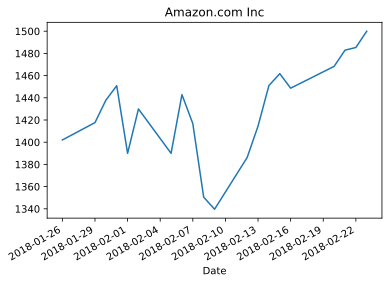

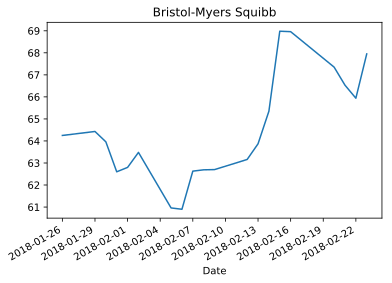

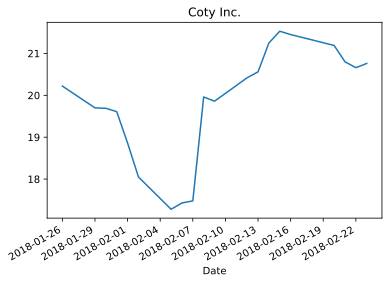

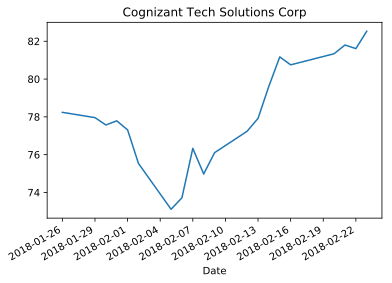

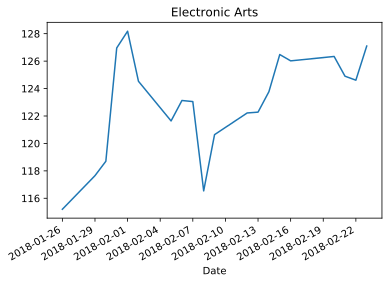

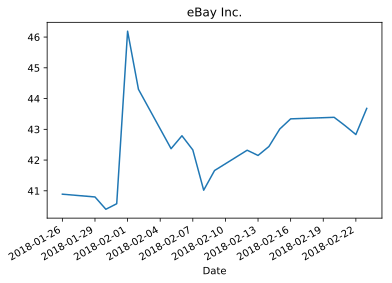

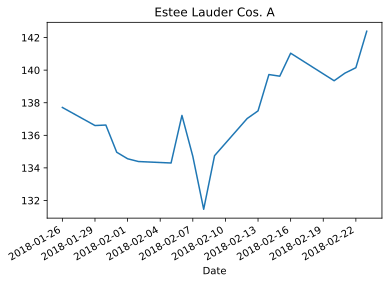

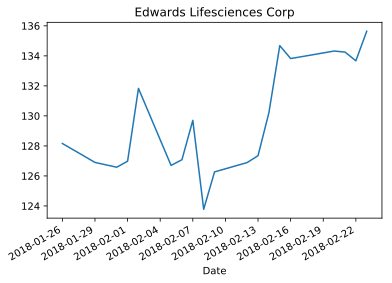

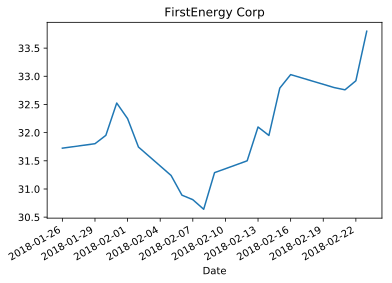

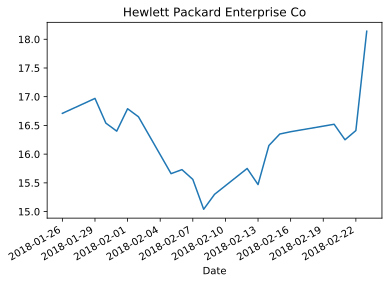

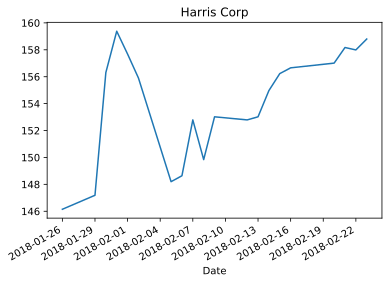

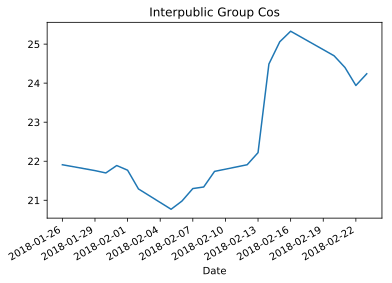

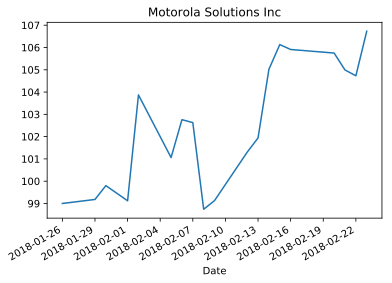

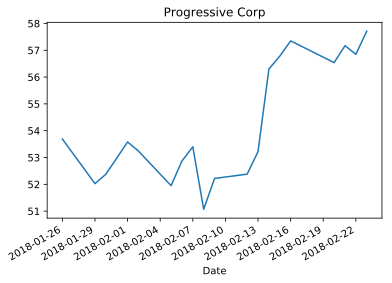

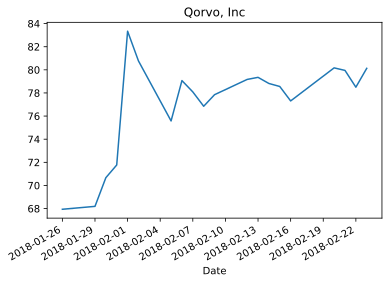

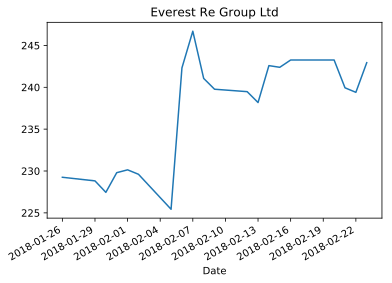

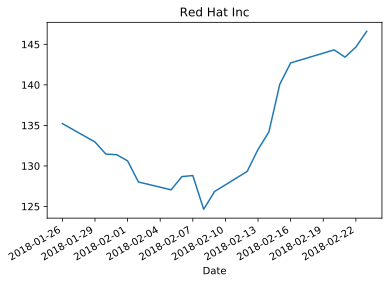

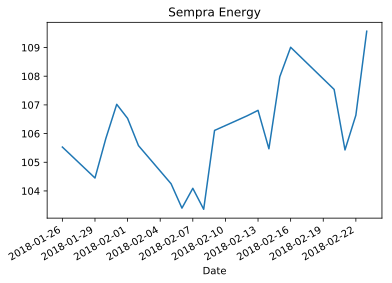

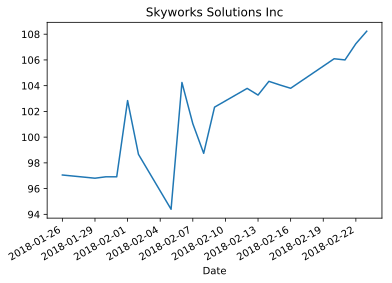

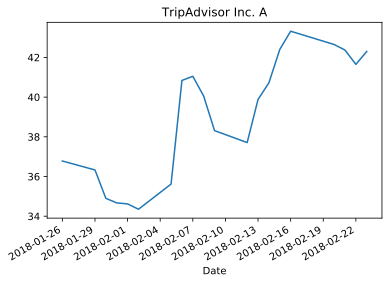

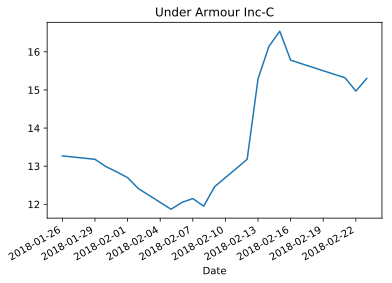

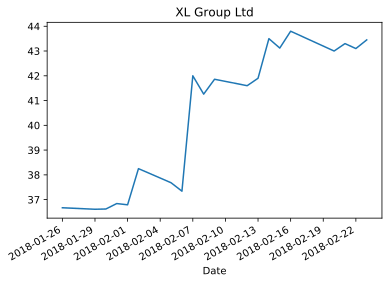

In [48]:
# plots all tickers to verify if there are any M&A targets
for t in recommend.sort_index().index:
    consol_px[t][-frame:].plot()
    plt.title(companies.loc[t]['Company'])
    plt.show()

In [59]:
re_group = recommend.groupby(by='Sector')
print("Total % Allocation {0:.2f}".format(recommend.Allocation.sum() * 100));
sector_cols = ['Sector Weight', 'Avg Posicion']
sector_df = pd.DataFrame([], index=pd.unique(recommend['Sector']), columns=sector_cols)
sector_df[sector_df.columns[0]] = re_group.sum()
sector_df[sector_df.columns[1]] = re_group.mean()
sector_df

Total % Allocation 99.42


,Sector Weight,Avg Posicion
XLU,0.100000,0.050000
XLK,0.322150,0.040269
XLP,0.072073,0.036036
XLY,0.200000,0.050000
XLI,0.050000,0.050000
XLV,0.100000,0.050000
XLF,0.150000,0.050000


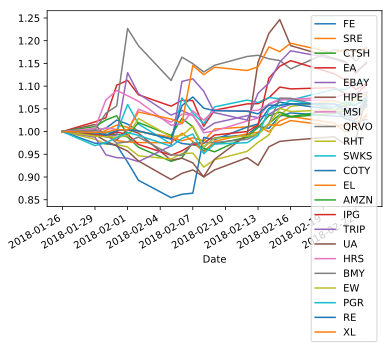

In [61]:
compound(consol_px[recommend.index][-lb:]).plot()

In [62]:
# Outputs for trade execution
px = consol_px[recommend.index][-lb:]
date = px[-1:].index.to_datetime().strftime(date_fmt)[0]
ret, risk = port_metrics(px_portion, rec) # HAS AN ISSUE HERE INCONSISTEN ***

trading_cols = ['Company', 'Price', 'Allocation', 'Dollar Value', 'Shares']
trading_df = pd.DataFrame([], index=rec.index, columns=trading_cols)

round_shares = lambda x: round(x, 0)
port_bal = 227000; alloc = rec.T.values
pvalue = (port_bal * alloc)
shares = (port_bal * alloc) / px[-1:]
shares.apply(round_shares).T.sort_index()

trading_df['Company'] = recommend['Company']
trading_df['Price'] = px[-1:].T
trading_df['Allocation'] = recommend['Allocation']
trading_df['Dollar Value'] = trading_df['Allocation'] * port_bal
trading_df['Shares'] = trading_df['Dollar Value'] / trading_df['Price']

print("Frame: {}, Lookback: {}, MinGrossAlloc: {}, MaxGrossAlloc: {}, MinWeight: {}, MaxWeight: {}".format(frame, lb, min_gross, max_gross, min_w, max_w))
print("Ann. Ret: {0:.2f}, Risk: {1:.2f} Sharpe: {2:.2f}".format(ret, risk, ret / risk))
print("Date: {0}, Total Invested: {1:.2f}, Total Allocation: {2:.2f}".format(date, trading_df['Dollar Value'].sum(), trading_df['Allocation'].sum() * 100))

trading_df
# Show some basic metrics like date, total value invested, and sum total allocation

Frame: 20, Lookback: 20, MinGrossAlloc: 0.5, MaxGrossAlloc: 1, MinWeight: 0, MaxWeight: 0.05
Ann. Ret: 2.30, Risk: 0.06 Sharpe: 35.73
Date: 02-23-2018, Total Invested: 225688.66, Total Allocation: 99.42


,Company,Price,Allocation,Dollar Value,Shares
FE,FirstEnergy Corp,33.799999,0.050000,11350.000000,335.798827
SRE,Sempra Energy,109.570000,0.050000,11350.000000,103.586748
CTSH,Cognizant Tech Solutions Corp,82.529999,0.012925,2934.040496,35.551200
EA,Electronic Arts,127.099998,0.050000,11350.000000,89.299765
EBAY,eBay Inc.,43.680000,0.037250,8455.689905,193.582644
HPE,Hewlett Packard Enterprise Co,18.139999,0.021975,4988.417524,274.995468
MSI,Motorola Solutions Inc,106.730003,0.050000,11350.000000,106.343106
QRVO,"Qorvo, Inc",80.129997,0.050000,11350.000000,141.644832
RHT,Red Hat Inc,146.619995,0.050000,11350.000000,77.410997
SWKS,Skyworks Solutions Inc,108.230003,0.050000,11350.000000,104.869257
